# import data


#Using apache spark

In [1]:
# Download Spark
%pip install pyspark
%pip install findspark

#Install implicit
%pip install implicit
%pip install pandas
%pip install numpy
%pip install os
%pip install matplotlib
%pip install seaborn
%pip install jupyter
%pip install wget
%pip install unzip


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribu

In [2]:
import pandas as pd


In [ ]:
import os
# Initialize findspark and create SparkSession
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("BookRecommendation") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "1g") \
    .config("spark.driver.host", "localhost") \
    .config("spark.driver.bindAddress", "localhost") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.default.parallelism", "200") \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .getOrCreate()



25/05/19 23:43:50 WARN Utils: Your hostname, GIAs-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 192.168.1.118 instead (on interface en0)
25/05/19 23:43:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/19 23:43:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 61434)
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/Library/Frameworks/Pyt

In [4]:
from pyspark.sql.functions import count, col, when, mean, rand  # Import all at once

In [5]:
#Check if we have the data
# Check if data files exist
if os.path.exists('Users.csv') and os.path.exists('Books.csv') and os.path.exists('Ratings.csv'):
    print("Data files already exist")
    exit
else:
    # Import data from GitHub using wget
    !wget -O data.zip 'https://github.com/giahuy1310/bookrecommendation/raw/main/BookDataset.zip'
    !unzip data.zip
    # Load data into Spark DataFrame
users = spark.read.csv('Users.csv', header=True, inferSchema=True)
books = spark.read.csv('Books.csv', header = True, inferSchema=True)
ratings = spark.read.csv('Ratings.csv', header=True, inferSchema=True)


Data files already exist


In [6]:
# Show schemas
books.printSchema()
ratings.printSchema()
users.printSchema()

root
 |-- ISBN: string (nullable = true)
 |-- Book-Title: string (nullable = true)
 |-- Book-Author: string (nullable = true)
 |-- Year-Of-Publication: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Image-URL-S: string (nullable = true)
 |-- Image-URL-M: string (nullable = true)
 |-- Image-URL-L: string (nullable = true)

root
 |-- User-ID: integer (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Book-Rating: integer (nullable = true)

root
 |-- User-ID: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: string (nullable = true)



In [7]:
# prompt:  change the type of the Age from string to float

from pyspark.sql.types import IntegerType

users = users.withColumn("Age", users["Age"].cast(IntegerType()))
users.printSchema()

root
 |-- User-ID: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: integer (nullable = true)



## Xử lý users
Bỏ những người rate hoặc tương tác ít hơn 5 cuốn

Xử lý tuổi null value

In [8]:
from pyspark.sql.functions import first, collect_list
process_user_age = users
process_user_age = process_user_age.withColumn("Age", process_user_age["Age"].cast(IntegerType()))
process_user_age.show()
process_user_age.printSchema()



+-------+--------------------+----+
|User-ID|            Location| Age|
+-------+--------------------+----+
|      1|  nyc, new york, usa|NULL|
|      2|stockton, califor...|  18|
|      3|moscow, yukon ter...|NULL|
|      4|porto, v.n.gaia, ...|  17|
|      5|farnborough, hant...|NULL|
|      6|santa monica, cal...|  61|
|      7| washington, dc, usa|NULL|
|      8|timmins, ontario,...|NULL|
|      9|germantown, tenne...|NULL|
|     10|albacete, wiscons...|  26|
|     11|melbourne, victor...|  14|
|     12|fort bragg, calif...|NULL|
|     13|barcelona, barcel...|  26|
|     14|mediapolis, iowa,...|NULL|
|     15|calgary, alberta,...|NULL|
|     16|albuquerque, new ...|NULL|
|     17|chesapeake, virgi...|NULL|
|     18|rio de janeiro, r...|  25|
|     19|           weston, ,|  14|
|     20|langhorne, pennsy...|  19|
+-------+--------------------+----+
only showing top 20 rows

root
 |-- User-ID: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: integer (nullab

In [9]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when
from pyspark.sql import SparkSession

# Assuming you have a SparkSession already initialized, if not:
spark = SparkSession.builder.appName("AgeImputation").getOrCreate()

# Your DataFrame is already loaded:
users_with_null_age = process_user_age

# 1. Identify categorical and numerical features (excluding 'User-ID' and 'Age')
categorical_cols = [col_name for col_name, dtype in users_with_null_age.dtypes if dtype == 'string' and col_name != 'User-ID']
numerical_cols = [col_name for col_name, dtype in users_with_null_age.dtypes if dtype in ['int', 'double', 'float'] and col_name != 'Age' and col_name != 'User-ID']

# 2. Index categorical features
indexers = [StringIndexer(inputCol=col, outputCol=col + '_index', handleInvalid='keep')
            for col in categorical_cols]

# 3. Assemble features into a single vector
assembler_inputs = [c + '_index' for c in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features', handleInvalid='keep')

# 4. Split the data into training and prediction sets
train_data = users_with_null_age.filter(col('Age').isNotNull())
predict_data = users_with_null_age.filter(col('Age').isNull()).drop('Age') # Drop the null 'Age' column for prediction

# 5. Define and train the Decision Tree Regressor
# Increase maxBins to accommodate the large number of categorical values
dt = DecisionTreeRegressor(featuresCol='features', labelCol='Age', maxBins=40969)  # Set maxBins to a value greater than the max number of categories
pipeline = Pipeline(stages=indexers + [assembler, dt])
model = pipeline.fit(train_data)

# 6. Make predictions for the null 'Age' values
predictions = model.transform(predict_data)

# 7. Select the predicted 'Age'
predicted_ages = predictions.select('User-ID', col('prediction').alias('Predicted_Age'))

# 8. Join the predicted ages back to the original DataFrame
users_filled_age = users_with_null_age.join(predicted_ages, 'User-ID', 'left')

# 9. Replace the null 'Age' values with the predicted ages
users_filled_age = users_filled_age.withColumn('Age', when(col('Age').isNull(), col('Predicted_Age')).otherwise(col('Age')))
# Convert Age to integer type
users_filled_age = users_filled_age.withColumn('Age', col('Age').cast('integer'))

# 10. Drop the 'Predicted_Age' column
users_filled_age = users_filled_age.drop('Predicted_Age')

# Show the DataFrame with filled 'Age' values
users_filled_age.show()

# If you need to use this processed DataFrame later, you can assign it back to a variable:
users = users_filled_age


25/05/19 23:43:55 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
25/05/19 23:43:56 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/19 23:43:56 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/19 23:43:56 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/05/19 23:44:01 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/05/19 23:44:06 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
25/05/19 23:44:11 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
25/05/19 23:44:16 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/05/19 23:44:27 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


+-------+--------------------+---+
|User-ID|            Location|Age|
+-------+--------------------+---+
|      1|  nyc, new york, usa| 32|
|      2|stockton, califor...| 18|
|      3|moscow, yukon ter...| 56|
|      4|porto, v.n.gaia, ...| 17|
|      5|farnborough, hant...|210|
|      6|santa monica, cal...| 61|
|      7| washington, dc, usa| 32|
|      8|timmins, ontario,...| 29|
|      9|germantown, tenne...| 40|
|     10|albacete, wiscons...| 26|
|     11|melbourne, victor...| 14|
|     12|fort bragg, calif...| 47|
|     13|barcelona, barcel...| 26|
|     14|mediapolis, iowa,...| 15|
|     15|calgary, alberta,...| 36|
|     16|albuquerque, new ...| 33|
|     17|chesapeake, virgi...| 39|
|     18|rio de janeiro, r...| 25|
|     19|           weston, ,| 14|
|     20|langhorne, pennsy...| 19|
+-------+--------------------+---+
only showing top 20 rows



In [10]:
# Join users and ratings
user_ratings = users.join(ratings, "User-ID")
user_ratings.show(5)
print(f"number of rows: {user_ratings.count()}")
print(f"number of columns: {len(user_ratings.columns)}")
print(f"number of users: {user_ratings.select('User-ID').distinct().count()}")
# Count ratings per user
user_rating_counts = user_ratings.groupBy("User-ID").count()

# Filter users with at least 10 ratings
active_users = user_rating_counts.filter(col("count") >= 10)

# Join back with original data to get full user information
filtered_user_ratings = user_ratings.join(
    active_users.select("User-ID"), 
    "User-ID"
)

# Show the processed data
print("Processed data sample:")
filtered_user_ratings.show(5)

# Show the shape
print("\nShape of processed data:")
print(f"Number of rows: {filtered_user_ratings.count()}")
print(f"Number of columns: {len(filtered_user_ratings.columns)}")
print(f"number of users: {filtered_user_ratings.select('User-ID').distinct().count()}")


25/05/19 23:44:28 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/05/19 23:44:29 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


+-------+--------------------+---+----------+-----------+
|User-ID|            Location|Age|      ISBN|Book-Rating|
+-------+--------------------+---+----------+-----------+
|     53|tacoma, washingto...| 39|0060914068|          3|
|     53|tacoma, washingto...| 39|0156047624|         10|
|     53|tacoma, washingto...| 39|0245542957|          6|
|     53|tacoma, washingto...| 39|0380715899|          9|
|     53|tacoma, washingto...| 39|0553280333|          0|
+-------+--------------------+---+----------+-----------+
only showing top 5 rows

number of rows: 1149780
number of columns: 5
number of users: 105283
Processed data sample:


25/05/19 23:44:31 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/05/19 23:44:32 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


+-------+--------------------+---+----------+-----------+
|User-ID|            Location|Age|      ISBN|Book-Rating|
+-------+--------------------+---+----------+-----------+
|    243|arden hills, minn...| 45|0060915544|         10|
|    243|arden hills, minn...| 45|0060977493|          7|
|    243|arden hills, minn...| 45|0140272100|          6|
|    243|arden hills, minn...| 45|0156006529|          0|
|    243|arden hills, minn...| 45|0312169787|          0|
+-------+--------------------+---+----------+-----------+
only showing top 5 rows


Shape of processed data:
Number of rows: 965713
Number of columns: 5
number of users: 13097


## Xử lý Rating
Mình sẽ dùng implicit rating hệ (0,1)
Đổi Nan, rating từ (1 ->5) là thành 0 (not good)
Đổi 0, rating từ (5->10) là thành 1 (good)

In [11]:
# Convert ratings to binary (0/1) based on the specified rules
filtered_user_ratings = filtered_user_ratings.withColumn(
    "implicit_rating",
    when(col("Book-Rating") >= 6, 1)     # Convert 6-10 to 1
    .when(col("Book-Rating") == 0, 1) # 0 rating
    .when(col("Book-Rating").isNull(), 0)  # Handle null values
    .otherwise(0)                          # Convert 1-5 to 0
)

# Show the processed data with new implicit ratings
print("Processed data with implicit ratings:")
filtered_user_ratings.show(5)
filtered_user_ratings.select("User-ID", "ISBN", "Book-Rating", "implicit_rating").show(5)

# Show the distribution of implicit ratings
print("\nDistribution of implicit ratings:")
filtered_user_ratings.groupBy("implicit_rating").count().show()


Processed data with implicit ratings:


25/05/19 23:44:33 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/05/19 23:44:34 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


+-------+--------------------+---+----------+-----------+---------------+
|User-ID|            Location|Age|      ISBN|Book-Rating|implicit_rating|
+-------+--------------------+---+----------+-----------+---------------+
|    243|arden hills, minn...| 45|0060915544|         10|              1|
|    243|arden hills, minn...| 45|0060977493|          7|              1|
|    243|arden hills, minn...| 45|0140272100|          6|              1|
|    243|arden hills, minn...| 45|0156006529|          0|              1|
|    243|arden hills, minn...| 45|0312169787|          0|              1|
+-------+--------------------+---+----------+-----------+---------------+
only showing top 5 rows

+-------+----------+-----------+---------------+
|User-ID|      ISBN|Book-Rating|implicit_rating|
+-------+----------+-----------+---------------+
|   5300|  54901467|          5|              0|
|   5300|880431138X|          0|              1|
|   5300|880433374X|          8|              1|
|   5300|880435

## Xử lí user with null age 

In [12]:
# Check for null values in books DataFrame
books_df = books.toPandas()
print("Checking for null values in books DataFrame:")
print(books_df.isnull().sum())  # This shows null counts for each column

# Drop rows with any null values
books_df = books_df.dropna()

# Verify that all null values have been removed
print("\nVerifying null values after dropping:")
print(books_df.isnull().sum())  # This should show all zeros

# Show the shape of the DataFrame after dropping null values
print(f"\nShape of books DataFrame after dropping null values: {books_df.shape[0]} rows")

Checking for null values in books DataFrame:
ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Verifying null values after dropping:
ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

Shape of books DataFrame after dropping null values: 271354 rows


## xử lí tuổi bị null value

In [13]:
# Filter users with age between 10 and 80 years old
filtered_users = filtered_user_ratings.filter((col("Age") >= 10) & (col("Age") <= 80))

# Count distinct users
distinct_users_count = filtered_users.select("User-ID").distinct().count()
print(f"\nNumber of distinct users: {distinct_users_count}")

# Show sample of filtered users
print("\nSample of filtered users:")
filtered_users.show(5)


25/05/19 23:44:38 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/05/19 23:44:38 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB



Number of distinct users: 12475

Sample of filtered users:


25/05/19 23:44:39 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


+-------+--------------------+---+----------+-----------+---------------+
|User-ID|            Location|Age|      ISBN|Book-Rating|implicit_rating|
+-------+--------------------+---+----------+-----------+---------------+
|    243|arden hills, minn...| 45|0060915544|         10|              1|
|    243|arden hills, minn...| 45|0060977493|          7|              1|
|    243|arden hills, minn...| 45|0140272100|          6|              1|
|    243|arden hills, minn...| 45|0156006529|          0|              1|
|    243|arden hills, minn...| 45|0312169787|          0|              1|
+-------+--------------------+---+----------+-----------+---------------+
only showing top 5 rows



25/05/19 23:44:39 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


25/05/19 23:44:40 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
25/05/19 23:44:41 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


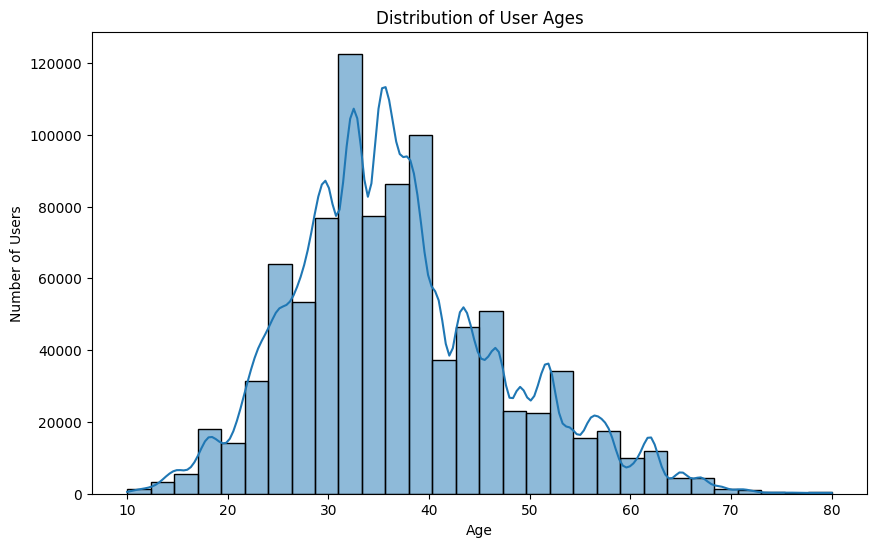

In [14]:
# prompt: draw the plot for the users_filtered

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming users_filtered is a Pandas DataFrame (convert if necessary)
# If users_filtered is a Spark DataFrame, convert it to Pandas:
filtered_users = filtered_users.toPandas()

# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(filtered_users['Age'], bins=30, kde=True)  # Adjust bins as needed
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.show()


# Làm việc với 3 bảng

In [15]:
users_rating_df = filtered_users

##Book table

In [16]:
print(f"Shape of Books DataFrame before potential duplicate removal: {books_df.shape}")
books_df.drop_duplicates(subset='ISBN', keep='first', inplace=True)
print(f"Shape of Books DataFrame after duplicate ISBN removal: {books_df.shape}")

Shape of Books DataFrame before potential duplicate removal: (271354, 8)
Shape of Books DataFrame after duplicate ISBN removal: (271354, 8)


In [17]:
print(books_df.head())

         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/

##Users_rating table

In [18]:
users_rating_df.head()


,User-ID,Location,Age,ISBN,Book-Rating,implicit_rating
0,243,"arden hills, minnesota, usa",45,0060915544,10,1
1,243,"arden hills, minnesota, usa",45,0060977493,7,1
2,243,"arden hills, minnesota, usa",45,0140272100,6,1
3,243,"arden hills, minnesota, usa",45,0156006529,0,1
4,243,"arden hills, minnesota, usa",45,0312169787,0,1


In [19]:
# Create total data dataframe
total_data_df = pd.merge(users_rating_df, books_df, on='ISBN', how='left')
# Check for NaN values in total_data_df
print("\nNaN values in total_data_df:")
print(total_data_df.isnull().sum())
# Show rows with NaN values
print("\nRows with NaN values:")
print(total_data_df[total_data_df.isnull().any(axis=1)].head())
# Drop NaN values from total_data_df
filtered_data_df = total_data_df.dropna()
print("\nShape after dropping NaN values:", total_data_df.shape)

print(f"Shape after filtering: {filtered_data_df.shape}")
filtered_data_df.head()



NaN values in total_data_df:
User-ID                    0
Location                   0
Age                        0
ISBN                       0
Book-Rating                0
implicit_rating            0
Book-Title             83979
Book-Author            83979
Year-Of-Publication    83979
Publisher              83979
Image-URL-S            83979
Image-URL-M            83979
Image-URL-L            83979
dtype: int64

Rows with NaN values:
    User-ID                     Location  Age        ISBN  Book-Rating  \
19      243  arden hills, minnesota, usa   45  0349109117            0   
78      243  arden hills, minnesota, usa   45  0880960043            0   
84      392  barcelona, catalunya, spain   44  8423646033            0   
86      392  barcelona, catalunya, spain   44  8429725544            0   
88      392  barcelona, catalunya, spain   44  8429727930            0   

    implicit_rating Book-Title Book-Author Year-Of-Publication Publisher  \
19                1        NaN      

,User-ID,Location,Age,ISBN,Book-Rating,implicit_rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,243,"arden hills, minnesota, usa",45,0060915544,10,1,The Bean Trees,Barbara Kingsolver,1989,Perennial,http://images.amazon.com/images/P/0060915544.0...,http://images.amazon.com/images/P/0060915544.0...,http://images.amazon.com/images/P/0060915544.0...
1,243,"arden hills, minnesota, usa",45,0060977493,7,1,The God of Small Things,Arundhati Roy,1998,Perennial,http://images.amazon.com/images/P/0060977493.0...,http://images.amazon.com/images/P/0060977493.0...,http://images.amazon.com/images/P/0060977493.0...
2,243,"arden hills, minnesota, usa",45,0140272100,6,1,Vanished,Mary McGarry Morris,1997,Penguin Books,http://images.amazon.com/images/P/0140272100.0...,http://images.amazon.com/images/P/0140272100.0...,http://images.amazon.com/images/P/0140272100.0...
3,243,"arden hills, minnesota, usa",45,0156006529,0,1,Where or When : A Novel,Anita Shreve,1999,Harvest Books,http://images.amazon.com/images/P/0156006529.0...,http://images.amazon.com/images/P/0156006529.0...,http://images.amazon.com/images/P/0156006529.0...
4,243,"arden hills, minnesota, usa",45,0312169787,0,1,The Red Tent : A Novel,Anita Diamant,1997,St. Martin's Press,http://images.amazon.com/images/P/0312169787.0...,http://images.amazon.com/images/P/0312169787.0...,http://images.amazon.com/images/P/0312169787.0...


# Colaborative filtering


## Matrix Factorization

In [20]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer

# Convert to Spark DataFrame
ratings_spark_df = spark.createDataFrame(total_data_df)
ratings_spark_df.printSchema()


25/05/19 23:44:57 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


root
 |-- User-ID: long (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Book-Rating: long (nullable = true)
 |-- implicit_rating: long (nullable = true)
 |-- Book-Title: string (nullable = true)
 |-- Book-Author: string (nullable = true)
 |-- Year-Of-Publication: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Image-URL-S: string (nullable = true)
 |-- Image-URL-M: string (nullable = true)
 |-- Image-URL-L: string (nullable = true)



In [21]:

isbn_indexer = StringIndexer(inputCol="ISBN", outputCol="bookId")
ratings_indexed = isbn_indexer.fit(ratings_spark_df).transform(ratings_spark_df)


25/05/19 23:45:19 WARN TaskSetManager: Stage 142 contains a task of very large size (1208 KiB). The maximum recommended task size is 1000 KiB.


In [22]:
(training, test) = ratings_indexed.randomSplit([0.8, 0.2], seed=42)


In [23]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# 1. Create the ALS model
als = ALS(
    maxIter=10,
    regParam=0.01,
    rank=10,  # Increased rank for more features
    userCol="User-ID",
    itemCol="bookId",
    ratingCol="implicit_rating",
    coldStartStrategy="drop",
    nonnegative=True,  # Ensures non-negative predictions
    implicitPrefs=True
)



In [24]:
# 2. Define parameter grid for tuning
param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [15]) \
    .addGrid(als.regParam, [0.05]) \
    .addGrid(als.maxIter, [15]) \
    .build()

In [25]:
# 3. Define evaluator
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="implicit_rating",
    predictionCol="prediction"
)

In [26]:
# 4. Create CrossValidator
cv = CrossValidator(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=2
)

In [27]:
# 6. Cache the datasets
training.cache()
test.cache()

# 7. Fit the model using cross-validation
print("Training model with cross-validation...")
cvModel = cv.fit(training)

Training model with cross-validation...


25/05/19 23:45:24 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
25/05/19 23:45:24 WARN TaskSetManager: Stage 145 contains a task of very large size (1208 KiB). The maximum recommended task size is 1000 KiB.
25/05/19 23:45:38 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
25/05/19 23:45:38 WARN TaskSetManager: Stage 146 contains a task of very large size (1208 KiB). The maximum recommended task size is 1000 KiB.
25/05/19 23:45:46 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
25/05/19 23:45:46 WARN TaskSetManager: Stage 147 contains a task of very large size (1208 KiB). The maximum recommended task size is 1000 KiB.
25/05/19 23:45:46 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
25/05/19 23:45:46 WARN TaskSetManager: Stage 148 contains a task of very large size (1208 KiB). The maximum recommended task size is 1000 KiB.
25/05/19 23:45:55 WARN DAGScheduler: Broadcasting large task binary with size 9.5 Mi

In [28]:
# 8. Get the best model
bestModel = cvModel.bestModel

# 9. Print the best parameters
# Print the best parameters
print("\nBest Model Parameters:")
print(f"Rank: {bestModel.rank}")
print("\nAll Model Parameters:")
print(bestModel.explainParams())


Best Model Parameters:
Rank: 15

All Model Parameters:
blockSize: block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data. (default: 4096)
coldStartStrategy: strategy for dealing with unknown or new users/items at prediction time. This may be useful in cross-validation or production scenarios, for handling user/item ids the model has not seen in the training data. Supported values: 'nan', 'drop'. (default: nan, current: drop)
itemCol: column name for item ids. Ids must be within the integer value range. (default: item, current: bookId)
predictionCol: prediction column name. (default: prediction)
userCol: column name for user ids. Ids must be within the integer value range. (default: user, current: User-ID)


In [29]:
# 10. Make predictions on validation set
predictions = bestModel.transform(test)


In [30]:
# 11. Evaluate final model
rmse = evaluator.evaluate(predictions)
print(f"\nRoot-mean-square error on validation set = {rmse}")

# 12. Show sample predictions
print("\nSample Predictions:")
predictions.select("User-ID", "ISBN", "implicit_rating", "prediction").show(5)


25/05/19 23:49:18 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
25/05/19 23:49:18 WARN TaskSetManager: Stage 2190 contains a task of very large size (1208 KiB). The maximum recommended task size is 1000 KiB.
25/05/19 23:49:19 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/19 23:49:19 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/19 23:49:29 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
25/05/19 23:49:30 WARN TaskSetManager: Stage 2226 contains a task of very large size (1208 KiB). The maximum recommended task size is 1000 KiB.
25/05/19 23:49:37 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
25/05/19 23:49:38 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
25/05/19 23:49:39 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB



Root-mean-square error on validation set = 0.9395816806134795

Sample Predictions:


25/05/19 23:49:39 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/19 23:49:39 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/19 23:49:39 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
25/05/19 23:49:40 WARN TaskSetManager: Stage 2304 contains a task of very large size (1208 KiB). The maximum recommended task size is 1000 KiB.
25/05/19 23:49:47 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


+-------+----------+---------------+-----------+
|User-ID|      ISBN|implicit_rating| prediction|
+-------+----------+---------------+-----------+
| 136943|1400034779|              1|0.017936502|
|  31556|1400034779|              1| 0.16494744|
|  60244|1400034779|              1| 0.85197943|
|  48494|1400034779|              1|0.105129786|
|  73394|1400034779|              1|  0.6363117|
+-------+----------+---------------+-----------+
only showing top 5 rows



25/05/19 23:49:48 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


In [31]:
# Add these debug prints after your predictions
print("Number of rows in predictions:", predictions.count())
print("Sample of predictions:")
predictions.show(5)

# Check for any null values
print("Number of null values in prediction column:", predictions.filter(col("prediction").isNull()).count())
print("Number of null values in Age column:", predictions.filter(col("Age").isNull()).count())

# Check the data types
print("Schema of predictions DataFrame:")
predictions.printSchema()

25/05/19 23:49:48 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/19 23:49:48 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/19 23:49:49 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
25/05/19 23:49:49 WARN TaskSetManager: Stage 2381 contains a task of very large size (1208 KiB). The maximum recommended task size is 1000 KiB.
25/05/19 23:49:56 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
25/05/19 23:49:57 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


Number of rows in predictions: 146898
Sample of predictions:


25/05/19 23:49:57 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/19 23:49:58 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/19 23:49:58 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
25/05/19 23:49:58 WARN TaskSetManager: Stage 2495 contains a task of very large size (1208 KiB). The maximum recommended task size is 1000 KiB.
25/05/19 23:50:06 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/05/19 23:50:08 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


+-------+--------------------+---+----------+-----------+---------------+--------------------+--------------------+-------------------+---------+--------------------+--------------------+--------------------+------+-----------+
|User-ID|            Location|Age|      ISBN|Book-Rating|implicit_rating|          Book-Title|         Book-Author|Year-Of-Publication|Publisher|         Image-URL-S|         Image-URL-M|         Image-URL-L|bookId| prediction|
+-------+--------------------+---+----------+-----------+---------------+--------------------+--------------------+-------------------+---------+--------------------+--------------------+--------------------+------+-----------+
| 136943|chesterfield, mis...| 43|1400034779|          0|              1|The No. 1 Ladies'...|Alexander McCall ...|               2003|   Anchor|http://images.ama...|http://images.ama...|http://images.ama...|  31.0|0.017936502|
|  31556|chula vista, cali...| 51|1400034779|          0|              1|The No. 1 Ladie

25/05/19 23:50:08 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/19 23:50:08 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/19 23:50:08 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
25/05/19 23:50:09 WARN TaskSetManager: Stage 2574 contains a task of very large size (1208 KiB). The maximum recommended task size is 1000 KiB.


Number of null values in Age column: 0
Schema of predictions DataFrame:
root
 |-- User-ID: long (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- Book-Rating: long (nullable = true)
 |-- implicit_rating: long (nullable = true)
 |-- Book-Title: string (nullable = true)
 |-- Book-Author: string (nullable = true)
 |-- Year-Of-Publication: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Image-URL-S: string (nullable = true)
 |-- Image-URL-M: string (nullable = true)
 |-- Image-URL-L: string (nullable = true)
 |-- bookId: double (nullable = false)
 |-- prediction: float (nullable = false)



In [32]:
# Recommend top 10 books for each user
user_recs = bestModel.recommendForAllUsers(10)
user_recs.show(truncate=False)


25/05/19 23:50:16 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|User-ID|recommendations                                                                                                                                                                                                                           |
+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|243    |[{0, 0.31370947}, {1, 0.24253939}, {2, 0.20925331}, {10, 0.20222141}, {9, 0.20214175}, {13, 0.2020737}, {3, 0.1814909}, {12, 0.17341855}, {36, 0.16706292}, {14, 0.16516985}]                                                             |
|392    |[{0, 0.0017

25/05/19 23:50:35 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


In [33]:
# Assuming you have `books` and `ratings_indexed` Spark DataFrames from the preceding code
# You also need the `isbn_indexer` fitted from the previous step to get the original ISBNs

# Get the mapping from indexed bookId back to original ISBN
# This can be done by accessing the labels from the fitted StringIndexer model
# You need to refit the indexer to get the labels again if the previous fit was not saved
fitted_isbn_indexer = isbn_indexer.fit(ratings_spark_df)
book_id_to_isbn = fitted_isbn_indexer.labels

# Create a Spark DataFrame for the book ID to ISBN mapping
# The index of the label corresponds to the indexed bookId
# Ensure the data type matches the bookId in the recommendations struct (IntegerType)
from pyspark.sql.types import IntegerType
book_id_mapping = spark.createDataFrame([(i, isbn) for i, isbn in enumerate(book_id_to_isbn)], ["bookId", "Original_ISBN"])
book_id_mapping = book_id_mapping.withColumn("bookId", col("bookId").cast(IntegerType())) # Cast to IntegerType

# Now, flatten the recommendations list to join with the main books DataFrame
from pyspark.sql.functions import explode

user_recs_exploded = user_recs.select("User-ID", explode("recommendations").alias("recommendation"))

# Join with the book ID to ISBN mapping
# Access the bookId from the exploded 'recommendation' struct
user_recs_with_isbn = user_recs_exploded.join(book_id_mapping, user_recs_exploded.recommendation.getItem("bookId") == book_id_mapping.bookId, "inner")

# Join with the original books DataFrame to get book details
# Ensure the 'ISBN' column in the 'books' DataFrame is consistent
# Assuming 'ISBN' is the correct column name in your original books Spark DataFrame
book_details_recs = user_recs_with_isbn.join(books, user_recs_with_isbn.Original_ISBN == books.ISBN, "inner")

# Select relevant columns
final_recommendations = book_details_recs.select(
    user_recs_with_isbn["User-ID"],
    user_recs_with_isbn.Original_ISBN.alias("Recommended_ISBN"),
    books["Book-Title"],
    books["Book-Author"],
    user_recs_with_isbn.recommendation.getItem("rating").alias("Estimated_Rating")
)

# Show the final recommendations with book details
final_recommendations.show(truncate=False)

25/05/19 23:50:35 WARN TaskSetManager: Stage 2649 contains a task of very large size (1208 KiB). The maximum recommended task size is 1000 KiB.
25/05/19 23:50:44 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/19 23:51:01 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


+-------+----------------+-----------------------------+----------------+----------------+
|User-ID|Recommended_ISBN|Book-Title                   |Book-Author     |Estimated_Rating|
+-------+----------------+-----------------------------+----------------+----------------+
|267587 |0553574566      |A Monstrous Regiment of Women|LAURIE R. KING  |0.0018906535    |
|142065 |0553574566      |A Monstrous Regiment of Women|LAURIE R. KING  |0.001354369     |
|176297 |0553574566      |A Monstrous Regiment of Women|LAURIE R. KING  |6.6474325E-4    |
|271066 |0553574566      |A Monstrous Regiment of Women|LAURIE R. KING  |0.004357644     |
|82795  |0553574566      |A Monstrous Regiment of Women|LAURIE R. KING  |0.00226217      |
|210481 |0553574566      |A Monstrous Regiment of Women|LAURIE R. KING  |0.0021315194    |
|566    |0553574566      |A Monstrous Regiment of Women|LAURIE R. KING  |0.0014367441    |
|65382  |034540288X      |The Lost World               |Michael Crichton|0.005603724     |

In [41]:
def evaluate_recommendations(model, test_data, k):
    # Get actual rated books for each user
    user_rated_books = test_data.groupBy("User-ID") \
        .agg(collect_list("bookId").alias("rated_books"))
    
    # Get unique users from test data
    users = test_data.select("User-ID").distinct()
    
    # Generate recommendations for all users
    recommendations = model.recommendForUserSubset(users, k)
    
    # Join recommendations with actual ratings
    evaluation_data = recommendations.join(user_rated_books, "User-ID")
    
    def calculate_user_metrics(row):
        # Extract book IDs from recommendations
        recommended = [r.bookId for r in row.recommendations]
        actual = set(row.rated_books)
        
        # Calculate hits (correct recommendations)
        hits = len(set(recommended) & actual)
        
        # Calculate precision and recall
        precision = hits / k if k > 0 else 0
        recall = hits / len(actual) if len(actual) > 0 else 0
        
        return (precision, recall)
    
    # Calculate metrics for each user
    metrics = evaluation_data.rdd.map(calculate_user_metrics).collect()
    
    # Average metrics across all users
    avg_precision = sum(p for p, _ in metrics) / len(metrics)
    avg_recall = sum(r for _, r in metrics) / len(metrics)
    
    return {
        'precision@k': avg_precision,
        'recall@k': avg_recall
    }


In [35]:
metrics = evaluate_recommendations(bestModel, training, k=10)
print(f"Precision@10: {metrics['precision@k']:.4f}")
f1_score = 2 * (metrics['precision@k'] * metrics['recall@k']) / (metrics['precision@k'] + metrics['recall@k']) if (metrics['precision@k'] + metrics['recall@k']) > 0 else 0
print(f"Recall@10: {metrics['recall@k']:.4f}")
print(f"F1-Score@10: {f1_score:.4f}")

25/05/19 23:51:08 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/19 23:51:08 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
25/05/19 23:51:08 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
25/05/19 23:51:08 WARN TaskSetManager: Stage 2800 contains a task of very large size (1208 KiB). The maximum recommended task size is 1000 KiB.
25/05/19 23:51:16 WARN TaskSetManager: Stage 2801 contains a task of very large size (1208 KiB). The maximum recommended task size is 1000 KiB.
25/05/19 23:51:17 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
25/05/19 23:51:24 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
25/05/19 23:51:24 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/19 23:51:25 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/19 23:51:37 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Precision@10: 0.0628
Recall@10: 0.0180
F1-Score@10: 0.0280


In [37]:
from pyspark.sql.functions import collect_list
import numpy as np
def calculate_map_ndcg(model, test_data, k=10):
    # Get actual rated books for each user
    user_rated_books = test_data.groupBy("User-ID") \
        .agg(collect_list("bookId").alias("rated_books"))
    
    # Generate recommendations for all users
    # Check if recommendations already exist
    if 'recommendations' in locals():
        pass
    else:
        # Get unique users from test data
        users = test_data.select("User-ID").distinct()
        # Generate recommendations for all users
        recommendations = model.recommendForUserSubset(users, k)
    # Join recommendations with actual ratings
    evaluation_data = recommendations.join(user_rated_books, "User-ID")
    
    def calculate_user_metrics(row):
        # Extract book IDs and scores from recommendations
        recommended = [(r.bookId, r.rating) for r in row.recommendations]
        actual = set(row.rated_books)
        
        # Calculate MAP@K
        ap = 0.0
        hits = 0
        for i, (book_id, _) in enumerate(recommended):
            if book_id in actual:
                hits += 1
                ap += hits / (i + 1)
        map_score = ap / len(actual) if len(actual) > 0 else 0
        
        # Calculate NDCG@K
        # Create ideal ranking (all relevant items first)
        ideal_ranking = [1.0] * len(actual) + [0.0] * (k - len(actual))
        
        # Calculate DCG
        dcg = 0.0
        for i, (book_id, _) in enumerate(recommended):
            if book_id in actual:
                dcg += 1.0 / np.log2(i + 2)  # log2(i+2) because i starts at 0
        
        # Calculate IDCG
        idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(actual), k)))
        
        # Calculate NDCG
        ndcg = dcg / idcg if idcg > 0 else 0
        
        return (map_score, ndcg)
    
    # Apply the metrics calculation
    metrics = evaluation_data.rdd.map(calculate_user_metrics).collect()
    
    # Calculate average MAP and NDCG
    avg_map = np.mean([m[0] for m in metrics])
    avg_ndcg = np.mean([m[1] for m in metrics])
    
    return {
        "map@k": avg_map,
        "ndcg@k": avg_ndcg
    }

# Calculate and print MAP@K and NDCG@K
map_ndcg_metrics = calculate_map_ndcg(bestModel, training, k=10)
print(f"MAP@10: {map_ndcg_metrics['map@k']:.4f}")
print(f"NDCG@10: {map_ndcg_metrics['ndcg@k']:.4f}")


25/05/19 23:52:46 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/19 23:52:47 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
25/05/19 23:52:47 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
25/05/19 23:52:47 WARN TaskSetManager: Stage 3084 contains a task of very large size (1208 KiB). The maximum recommended task size is 1000 KiB.
25/05/19 23:52:56 WARN TaskSetManager: Stage 3085 contains a task of very large size (1208 KiB). The maximum recommended task size is 1000 KiB.
25/05/19 23:52:57 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
25/05/19 23:53:03 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
25/05/19 23:53:03 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/19 23:53:04 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/19 23:53:12 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


MAP@10: 0.0077
NDCG@10: 0.0714


In [38]:
filtered_user_ratings.show(5)

25/05/19 23:54:15 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


+-------+--------------------+---+----------+-----------+---------------+
|User-ID|            Location|Age|      ISBN|Book-Rating|implicit_rating|
+-------+--------------------+---+----------+-----------+---------------+
|    243|arden hills, minn...| 45|0060915544|         10|              1|
|    243|arden hills, minn...| 45|0060977493|          7|              1|
|    243|arden hills, minn...| 45|0140272100|          6|              1|
|    243|arden hills, minn...| 45|0156006529|          0|              1|
|    243|arden hills, minn...| 45|0312169787|          0|              1|
+-------+--------------------+---+----------+-----------+---------------+
only showing top 5 rows



25/05/19 23:54:17 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


In [69]:
# Create mapping between numeric IDs and ISBNs
# Assuming you have the original mapping from when you created the model
fitted_isbn_indexer = isbn_indexer.fit(ratings_spark_df)
book_id_to_isbn = fitted_isbn_indexer.labels

# Create a reverse mapping (ISBN to numeric ID)
isbn_to_id = {isbn: idx for idx, isbn in enumerate(book_id_to_isbn)}

def get_reranked_recommendations(user_id, current_book_isbn, num_recommendations=10):
    # Convert ISBN to numeric ID
    current_book_id = isbn_to_id.get(current_book_isbn)
    if current_book_id is None:
        print(f"Book ISBN {current_book_isbn} not found in the mapping")
        return None
    print(f"Current book ID: {current_book_id}")
    
    # Step 1: Get initial ALS recommendations
    try:
        user_recs = bestModel.recommendForUserSubset(
            spark.createDataFrame([(user_id,)], ["User-ID"]), 
            num_recommendations
        )
        user_recs = user_recs.collect()
        
        if not user_recs:
            print(f"No recommendations found for user {user_id}")
            return None
        
        # Get recommendations list
        recommendations = user_recs[0].recommendations
        
        # Step 2: Get the current book's features
        current_book_features = None
        for item in bestModel.itemFactors.collect():
            if item.id == current_book_id:
                current_book_features = np.array(item.features)
                break
        if current_book_features is None:
            print(f"Current book ID {current_book_id} not found in the model")
            return None
        
        # Step 3: Calculate similarities and create a list of (ISBN, rating, similarity)
        recommendations_with_similarity = []
        for rec in recommendations:  # Use recommendations instead of user_recs[0].recommendations
            rec_features = None
            for item in bestModel.itemFactors.collect():
                if item.id == rec.bookId:
                    rec_features = np.array(item.features)
                    break
            
            if rec_features is not None:
                # Convert current book features to numpy array if not already
                if not isinstance(current_book_features, np.ndarray):
                    current_book_features = np.array(current_book_features)
                
                # Calculate cosine similarity using numpy
                dot_product = np.dot(current_book_features, rec_features)
                norm_current = np.linalg.norm(current_book_features)
                norm_rec = np.linalg.norm(rec_features)
                similarity = float(dot_product / (norm_current * norm_rec))
                
                # Convert numeric ID back to ISBN for display
                isbn = book_id_to_isbn[rec.bookId]
                recommendations_with_similarity.append((isbn, rec.rating, similarity))
            else:
                print(f"Could not find features for bookId: {rec.bookId}")
        
        if not recommendations_with_similarity:
            print("No similar books found")
            return None
        
        # Step 4: Create DataFrames for recommendations and similarities
        recommendations_df = spark.createDataFrame(
            [(isbn, rating) for isbn, rating, _ in recommendations_with_similarity],
            ["ISBN", "rating"]
        )
        
        similarities_df = spark.createDataFrame(
            [(isbn, similarity) for isbn, _, similarity in recommendations_with_similarity],
            ["ISBN", "Similarity"]
        )
        
        # Step 5: Join with book details and similarities
        book_details_recs = recommendations_df.join(
            books,
            recommendations_df.ISBN == books.ISBN,
            "inner"
        ).join(
            similarities_df,
            recommendations_df.ISBN == similarities_df.ISBN,
            "inner"
        )
        
        # Step 6: Calculate final score (combine ALS rating and similarity)
        als_weight = 0.7
        similarity_weight = 0.3
        
        final_recommendations = book_details_recs.select(
            books["ISBN"],
            books["Book-Title"],
            books["Book-Author"],
            recommendations_df["rating"].alias("ALS_Rating"),
            similarities_df["Similarity"],
            (recommendations_df["rating"] * als_weight + 
             similarities_df["Similarity"] * similarity_weight).alias("Final_Score")
        ).orderBy("Final_Score", ascending=False)
        # Filter recommendations to only include those with similarity > 0.5
        final_recommendations = final_recommendations.filter(
            similarities_df["Similarity"] > 0.3
        )
        return final_recommendations
        
    except Exception as e:
        print(f"Error getting recommendations: {str(e)}")
        return None

25/05/20 01:28:00 WARN TaskSetManager: Stage 11918 contains a task of very large size (1208 KiB). The maximum recommended task size is 1000 KiB.


In [71]:
# Get 50 random users and books for testing
random_users = ratings_spark_df.select("User-ID").distinct().limit(5)
random_books = ratings_spark_df.select("ISBN").distinct().limit(5)

# Collect the users and books as lists
user_list = [row["User-ID"] for row in random_users.collect()]
book_list = [row["ISBN"] for row in random_books.collect()]

print("Generating recommendations for 50 users and 50 books...")

# Initialize empty lists to store results
all_recommendations = []

# Generate recommendations for each user-book pair
for user in user_list:
    for book in book_list:
        try:
            # Get recommendations
            recs = get_reranked_recommendations(user, book, num_recommendations=5)
            if recs:
                # Convert to pandas and add source user/book info
                recs_pd = recs.toPandas()
                recs_pd['Source_User'] = user
                recs_pd['Source_Book'] = book
                all_recommendations.append(recs_pd)
                
        except Exception as e:
            print(f"Error getting recommendations for user {user}, book {book}: {str(e)}")
            continue

print("\nFinished generating recommendations")

# Combine all results
if all_recommendations:
    all_recs_df = pd.concat(all_recommendations, ignore_index=True)
    print("\nSample of recommendations:")
    print(all_recs_df.head())
else:
    print("No recommendations were generated successfully")


25/05/20 01:30:23 WARN TaskSetManager: Stage 13121 contains a task of very large size (1208 KiB). The maximum recommended task size is 1000 KiB.
25/05/20 01:30:27 WARN TaskSetManager: Stage 13124 contains a task of very large size (1208 KiB). The maximum recommended task size is 1000 KiB.
25/05/20 01:30:36 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Generating recommendations for 50 users and 50 books...
Current book ID: 232890


25/05/20 01:30:39 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:30:39 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:30:40 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:30:41 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:30:43 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:30:45 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:30:48 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:30:50 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:30:53 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 13183


25/05/20 01:31:01 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:05 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:05 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:06 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:06 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:09 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:13 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:16 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:19 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:22 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 399


25/05/20 01:31:31 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:34 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:35 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:35 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:36 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:39 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:41 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:43 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:46 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:48 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 101155


25/05/20 01:31:56 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:58 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:59 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:31:59 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:00 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:02 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:04 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:06 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:08 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:10 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 15652


25/05/20 01:32:18 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:21 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:21 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:22 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:22 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:24 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:26 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:28 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:30 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:32 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 232890


25/05/20 01:32:39 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:42 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:42 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:43 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:43 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:45 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:47 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:49 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:51 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:32:55 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 13183


25/05/20 01:33:01 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:04 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:05 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:06 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:06 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:08 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:11 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:12 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:14 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:17 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 399


25/05/20 01:33:24 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:27 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:28 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:28 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:29 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:31 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:33 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:36 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:37 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:40 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 101155


25/05/20 01:33:47 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:50 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:50 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:51 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:52 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:54 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:57 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:33:59 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:02 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:05 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 15652


25/05/20 01:34:12 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:15 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:15 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:15 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:16 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:19 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:22 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:24 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:26 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:28 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 232890


25/05/20 01:34:36 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:39 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:39 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:40 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:40 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:42 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:45 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:47 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:49 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:52 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:34:58 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 13183


25/05/20 01:35:01 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:01 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:02 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:02 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:04 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:06 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:09 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:10 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:12 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:19 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 399


25/05/20 01:35:22 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:22 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:23 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:23 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:25 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:28 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:31 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:33 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:34 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:41 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 101155


25/05/20 01:35:44 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:44 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:45 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:45 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:47 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:49 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:51 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:53 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:35:55 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 15652


25/05/20 01:36:02 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:04 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:05 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:05 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:06 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:08 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:10 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:12 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:15 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:17 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 232890


25/05/20 01:36:24 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:27 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:27 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:28 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:28 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:30 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:33 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:36 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:38 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:40 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 13183


25/05/20 01:36:47 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:49 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:50 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:51 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:51 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:53 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:55 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:57 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:36:58 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:00 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 399


25/05/20 01:37:06 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:09 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:09 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:10 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:10 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:13 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:15 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:17 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:19 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:22 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 101155


25/05/20 01:37:29 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:31 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:31 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:32 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:33 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:35 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:37 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:39 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:41 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:43 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 15652


25/05/20 01:37:50 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:52 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:53 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:53 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:54 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:56 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:37:58 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:00 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:02 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:04 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 232890


25/05/20 01:38:10 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:12 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:13 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:13 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:13 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:16 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:18 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:20 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:22 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:24 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 13183


25/05/20 01:38:30 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:33 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:33 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:33 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:34 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:36 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:37 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:39 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:41 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:43 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 399


25/05/20 01:38:48 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:51 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:51 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:52 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:52 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:54 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:56 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:38:58 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:39:00 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:39:02 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 101155


25/05/20 01:39:07 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:39:10 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:39:10 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:39:11 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:39:11 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:39:13 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:39:15 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:39:17 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:39:19 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:39:22 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


Current book ID: 15652


25/05/20 01:39:28 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:39:31 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:39:32 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:39:32 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:39:33 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:39:35 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:39:37 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:39:39 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:39:41 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
25/05/20 01:39:43 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB



Finished generating recommendations

Sample of recommendations:
         ISBN                 Book-Title   Book-Author  ALS_Rating  \
0  0971880107                Wild Animus  Rich Shapero    0.313709   
1  0385504209          The Da Vinci Code     Dan Brown    0.209253   
2  0316666343  The Lovely Bones: A Novel  Alice Sebold    0.242539   
3  0971880107                Wild Animus  Rich Shapero    0.313709   
4  0385504209          The Da Vinci Code     Dan Brown    0.209253   

   Similarity  Final_Score  Source_User Source_Book  
0    0.950468     0.504737          243  0870114247  
1    0.889888     0.413444          243  0870114247  
2    0.736475     0.390720          243  0870114247  
3    0.960509     0.507749          243  0140440488  
4    0.865673     0.406179          243  0140440488  


In [72]:
print(all_recs_df)

          ISBN                 Book-Title       Book-Author  ALS_Rating  \
0   0971880107                Wild Animus      Rich Shapero    0.313709   
1   0385504209          The Da Vinci Code         Dan Brown    0.209253   
2   0316666343  The Lovely Bones: A Novel      Alice Sebold    0.242539   
3   0971880107                Wild Animus      Rich Shapero    0.313709   
4   0385504209          The Da Vinci Code         Dan Brown    0.209253   
..         ...                        ...               ...         ...   
82  044021145X                   The Firm      John Grisham    0.029641   
83  0440214041          The Pelican Brief      John Grisham    0.031580   
84  0440211727             A Time to Kill      JOHN GRISHAM    0.033835   
85  0440213525                 The Client      John Grisham    0.027104   
86  0345370775              Jurassic Park  Michael Crichton    0.029287   

    Similarity  Final_Score  Source_User Source_Book  
0     0.950468     0.504737          243  08

In [73]:
all_recs_df.to_csv("reranked_recommendations.csv", index=False)

In [75]:
import pickle
pickle.dump(all_recs_df, open('reranked_recommendations.pkl', 'wb'))

### With implicit data